
# **나의 해방일지**

---

# 12월 05일 <br>
Stage 1. 수업 시간에 배운 MNIST 데이터를 이용해서 손글씨 숫자 판별을 가능케 하는 딥러닝 모델 구축

1.   epoch을 35으로 줄였다.
2.   CNN 모델의 모든 layer의 node갯수를 일정하게 잡고 해서, node의 갯수의 변화를 주었다.

epoch은 30 이후로 accuracy가 크게 변하지 않았기 때문에 줄였고, CNN 모델 layer은 그대로 유지하되 layer안에 node의 갯수가 이전에 64로 통일되어있다는 문제를 식별하였다. 그래서 node갯수를 514, 256,128 등으로 변화를 주어 학습이 잘되도록 유도하였다.

<br> Accuracy: 92.13 %
<br> node의 개수를 변해도 크게 모델의 성능에 변화가 없었다.

<br> 결론: 지금껏 데이터 셋을 Fashion MNIST 데이터셋을 사용했기 때문에 생긴 문제라는 것을 포착하였다. 다음 시도 때는 숫자 데이터셋을 사용한 MNIST데이터셋으로 훈련 시켜보고자 한다.









In [ ]:
import torch
from torch import nn
from torchvision import datasets, transforms 
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%config InlineBackend.figure_format='retina'

In [ ]:
torch.manual_seed(316)

In [ ]:
transform = transforms.Compose(
  [
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
] )

In [ ]:
dataset = datasets.FashionMNIST('.', download=True, train=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



In [ ]:
len_trainset = int(len(dataset) * 0.8)
len_valset = len(dataset) - len_trainset
trainset, valset = torch.utils.data.random_split(dataset, [len_trainset, len_valset])

In [ ]:
batch_size = 64
trainloader = torch.utils.data.DataLoader(
trainset, batch_size=batch_size, shuffle=True
)

In [ ]:
valloader = torch.utils.data.DataLoader(
  valset,
  batch_size=batch_size,
  shuffle=True )

In [ ]:
 idx_to_class = { v:k for k, v in trainset.dataset.class_to_idx.items() } 
 idx_to_class

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [ ]:
images, labels = next(iter(trainloader))
images.shape

torch.Size([64, 1, 28, 28])

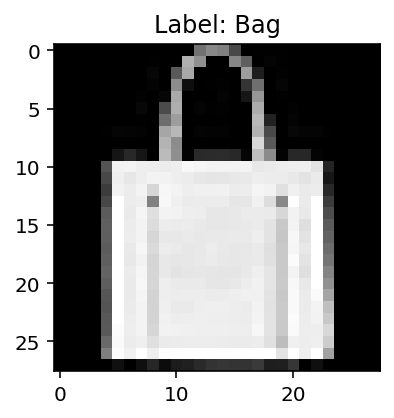

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
img_idx = 0
label = idx_to_class[int(labels[0])]
ax.imshow(images[0][0], cmap="gray")
ax.set_title(f"Label: {label}")
plt.show()

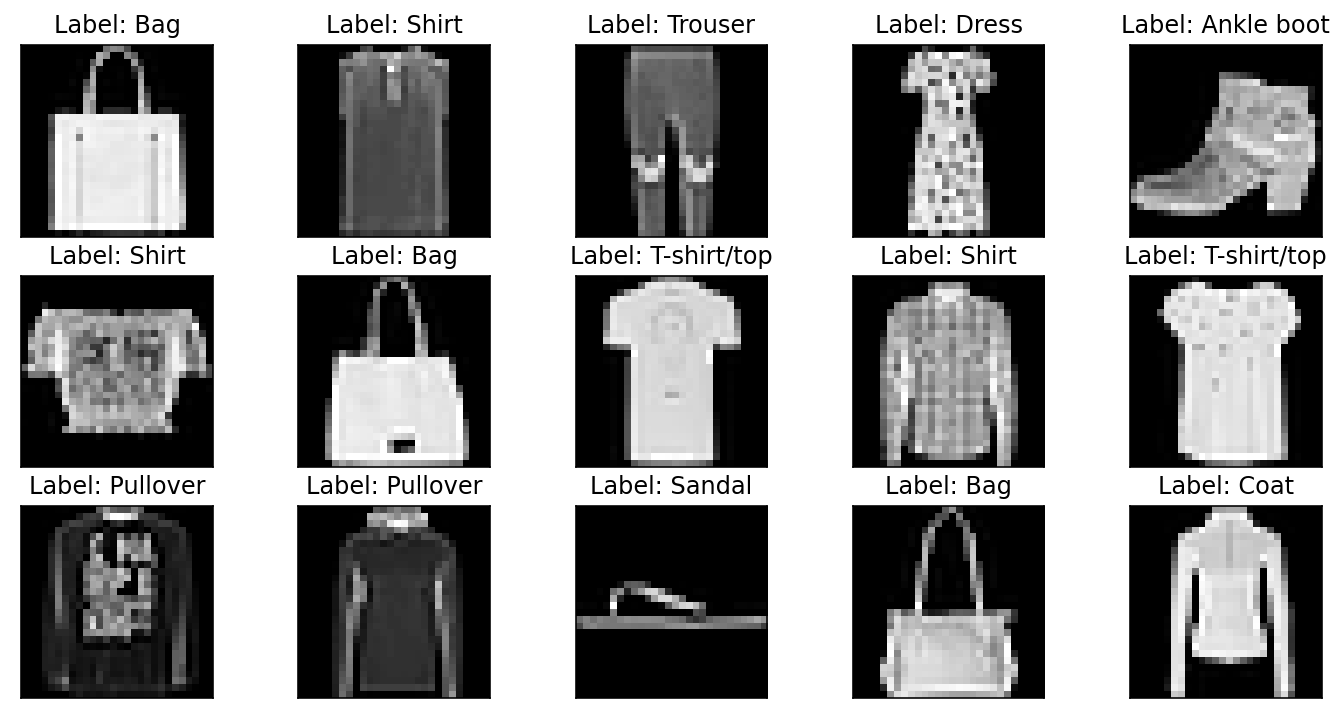

In [ ]:
fig, ax = plt.subplots(ncols=5, nrows=3, figsize=(12,6))
ax = np.ravel(ax)
for index in range(15): 
  ax[index].imshow(images[index][0], cmap="gray")
  label = idx_to_class[int(labels[index])] 
  ax[index].set_title(f"Label: {label}") 
  ax[index].set_xticks([]) 
  ax[index].set_yticks([])
plt.show()

In [ ]:
from collections import OrderedDict 

class Network(nn.Module): 

  def __init__(self):
    super().__init__()
    self.feature_extraction = nn.Sequential(
            nn.Conv2d(1, 512, kernel_size=7,stride = 1, padding=3), 
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5, stride =1,padding= 1),
            nn.Conv2d(512, 256, kernel_size=3,stride = 1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3,stride = 1, padding=1), 
            nn.Conv2d(128, 64, kernel_size=3,stride = 1, padding=1), 
            nn.ReLU(),
            nn.Conv2d(64, 32, kernel_size=3,stride = 1, padding=1),
            nn.Conv2d(32, 100, kernel_size=3,stride = 1, padding=1),
            nn.Conv2d(100, 200, kernel_size=3,stride = 1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=5,  stride =1)
            )
    self.classifier = nn.Sequential(
            nn.Linear(22*22*200, 2048), 
            nn.BatchNorm1d(2048), 
            nn.Dropout(p=0.5), 
            nn.ReLU(),
            nn.Linear(2048, 100)
            )
    
  def forward(self, x: torch.Tensor) -> torch.Tensor: 
    out1 = self.feature_extraction(x)
    out2 = torch.flatten(out1, 1)
    out3 = self.classifier(out2)
    return out3 

model = Network()

In [ ]:
from torchsummary import summary 
summary(model, (1, 28, 28), device="cpu")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 512, 28, 28]          25,600
              ReLU-2          [-1, 512, 28, 28]               0
         MaxPool2d-3          [-1, 512, 26, 26]               0
            Conv2d-4          [-1, 256, 26, 26]       1,179,904
              ReLU-5          [-1, 256, 26, 26]               0
            Conv2d-6          [-1, 128, 26, 26]         295,040
            Conv2d-7           [-1, 64, 26, 26]          73,792
              ReLU-8           [-1, 64, 26, 26]               0
            Conv2d-9           [-1, 32, 26, 26]          18,464
           Conv2d-10          [-1, 100, 26, 26]          28,900
           Conv2d-11          [-1, 200, 26, 26]         180,200
             ReLU-12          [-1, 200, 26, 26]               0
        MaxPool2d-13          [-1, 200, 22, 22]               0
           Linear-14                 [-

In [ ]:
total_params = 0
for name, param in model.named_parameters():
    print(name, param.shape, param.numel())
    total_params += param.numel()
print(f"Total number of parameters = {total_params}")

feature_extraction.0.weight torch.Size([512, 1, 7, 7]) 25088
feature_extraction.0.bias torch.Size([512]) 512
feature_extraction.3.weight torch.Size([256, 512, 3, 3]) 1179648
feature_extraction.3.bias torch.Size([256]) 256
feature_extraction.5.weight torch.Size([128, 256, 3, 3]) 294912
feature_extraction.5.bias torch.Size([128]) 128
feature_extraction.6.weight torch.Size([64, 128, 3, 3]) 73728
feature_extraction.6.bias torch.Size([64]) 64
feature_extraction.8.weight torch.Size([32, 64, 3, 3]) 18432
feature_extraction.8.bias torch.Size([32]) 32
feature_extraction.9.weight torch.Size([100, 32, 3, 3]) 28800
feature_extraction.9.bias torch.Size([100]) 100
feature_extraction.10.weight torch.Size([200, 100, 3, 3]) 180000
feature_extraction.10.bias torch.Size([200]) 200
classifier.0.weight torch.Size([2048, 96800]) 198246400
classifier.0.bias torch.Size([2048]) 2048
classifier.1.weight torch.Size([2048]) 2048
classifier.1.bias torch.Size([2048]) 2048
classifier.4.weight torch.Size([100, 2048])

In [ ]:
import time

from torch import optim
# set up an optimizer (pass parameters to be optimized and a learning rate)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
# define the loss
criterion = nn.CrossEntropyLoss()

In [ ]:
 import torch
 
 device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
 device

 model.to(device)

Network(
  (feature_extraction): Sequential(
    (0): Conv2d(1, 512, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=5, stride=1, padding=1, dilation=1, ceil_mode=False)
    (3): Conv2d(512, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): Conv2d(32, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): MaxPool2d(kernel_size=5, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=96800, out_features=2048, bias=True)
    (1): BatchNorm1d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [ ]:
start_time = time.time()
n_epochs = 35
train_loss_history = []
val_loss_history = []
accuracy_history = []
for epoch in range(n_epochs): 
  train_loss = 0
  model.train()
  for images, labels in trainloader:
    images, labels = images.to(device), labels.to(device) # zero the gradients on each training pass
    optimizer.zero_grad()
    # make a forward pass through the network
    logits = model.forward(images)
    # use the network output to calculate the loss (output vs. ground truth)
    loss = criterion(logits, labels)
        # make a backward pass through the network to calculate the gradients (backpropagation)
    loss.backward()
    # update the weights
    optimizer.step()
    # keep track of the loss per epoch
    train_loss += loss.item() 
  else:
    train_loss = train_loss / len(trainloader)
    train_loss_history.append(train_loss)
    val_loss = 0
    accuracy = 0
    with torch.no_grad(): 
      model.eval()
      for images, labels in valloader:
        images, labels = images.to(device), labels.to(device) 
        logits = model.forward(images)
        loss = criterion(logits, labels)
        val_loss += loss.item()
        probabilities = logits.softmax(dim=1)
        top_probs, top_classes = probabilities.topk(k=1, dim=1)
        corrects = (top_classes == labels.view(*top_classes.shape))          
        accuracy += torch.mean(corrects.type(torch.FloatTensor))
    val_loss = val_loss / len(valloader)
    val_loss_history.append(val_loss)
    accuracy = accuracy / len(valloader)
    accuracy_history.append(accuracy)
    metrics = f"Epoch: {epoch + 1:02}/{n_epochs:02}" 
    metrics += " | "
    metrics += f"Train loss: {train_loss:.3f}" 
    metrics += " | "
    metrics += f"Validation loss: {val_loss:.3f}" 
    metrics += " | "
    metrics += f"Accuracy: {accuracy:.3f}" 
    print(metrics)
print("Elapsed: {0:.2f} seconds".format(time.time() - start_time))

Epoch: 01/35 | Train loss: 0.424 | Validation loss: 0.343 | Accuracy: 0.877
Epoch: 02/35 | Train loss: 0.286 | Validation loss: 0.265 | Accuracy: 0.902
Epoch: 03/35 | Train loss: 0.249 | Validation loss: 0.345 | Accuracy: 0.872
Epoch: 04/35 | Train loss: 0.221 | Validation loss: 0.342 | Accuracy: 0.879
Epoch: 05/35 | Train loss: 0.201 | Validation loss: 0.246 | Accuracy: 0.909
Epoch: 06/35 | Train loss: 0.185 | Validation loss: 0.226 | Accuracy: 0.916
Epoch: 07/35 | Train loss: 0.169 | Validation loss: 0.214 | Accuracy: 0.921
Epoch: 08/35 | Train loss: 0.150 | Validation loss: 0.217 | Accuracy: 0.922
Epoch: 09/35 | Train loss: 0.137 | Validation loss: 0.211 | Accuracy: 0.924
Epoch: 10/35 | Train loss: 0.122 | Validation loss: 0.212 | Accuracy: 0.926
Epoch: 11/35 | Train loss: 0.104 | Validation loss: 0.218 | Accuracy: 0.922
Epoch: 12/35 | Train loss: 0.094 | Validation loss: 0.250 | Accuracy: 0.919
Epoch: 13/35 | Train loss: 0.078 | Validation loss: 0.215 | Accuracy: 0.927
Epoch: 14/35

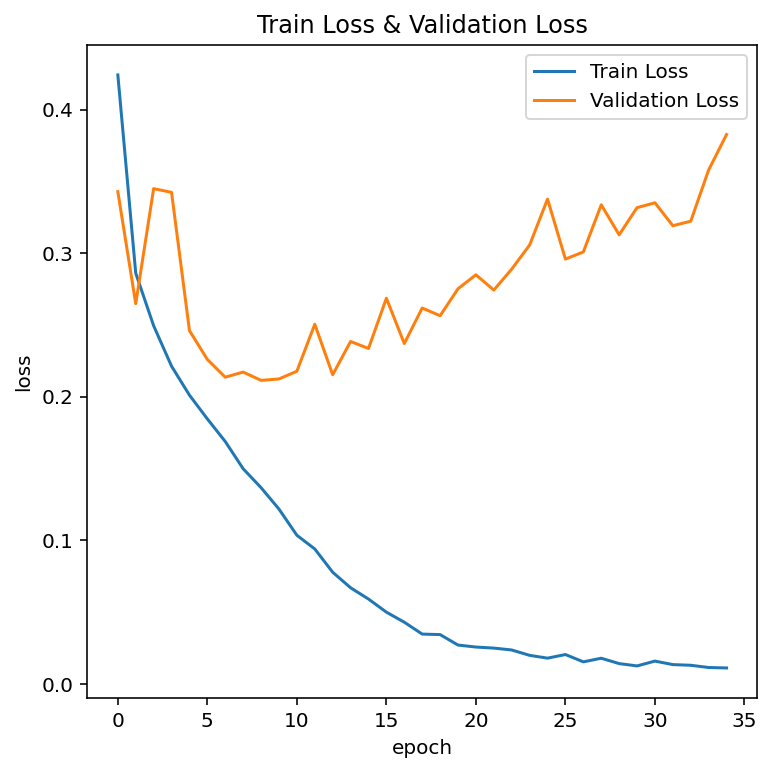

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.plot(train_loss_history, label="Train Loss")
ax.plot(val_loss_history, label="Validation Loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("Train Loss & Validation Loss")
ax.legend()
plt.show()

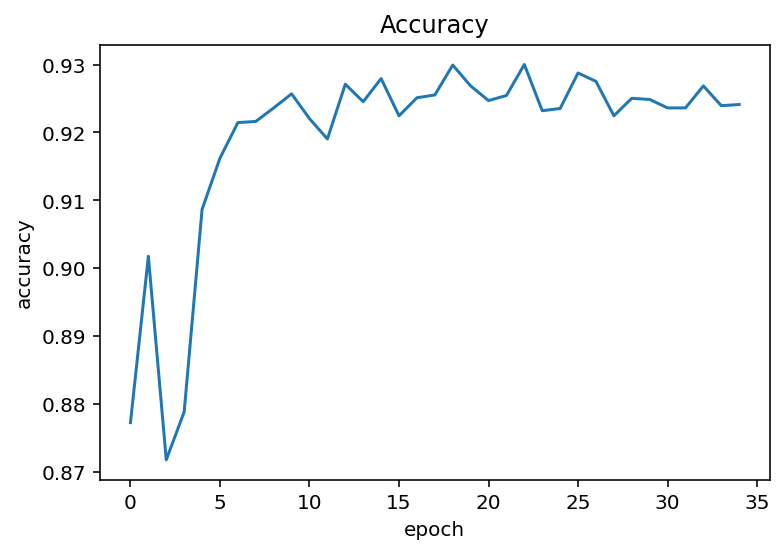

In [ ]:
fig, ax = plt.subplots()
ax.plot(accuracy_history, label="Accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy")
plt.show()

In [ ]:
# download the testset
testset = datasets.FashionMNIST('.', download=True, train=False, transform=transform)
# loader for the testset
testloader = torch.utils.data.DataLoader( testset,
batch_size=batch_size,
shuffle=True
)

In [ ]:
total = 0 
total_corrects = 0 
with torch.no_grad():
  for images, labels in testloader:
    images, labels = images.to(device), labels.to(device) 
    logits = model.forward(images)
    probabilities = logits.softmax(dim=1)
    top_probs, top_classes = probabilities.topk(k=1, dim=1)
    corrects = (top_classes == labels.view(*top_classes.shape))
    corrects = int(torch.sum(corrects).cpu().numpy())
    total_corrects += corrects
    total += labels.size(0)

In [ ]:
total_corrects / total * 100.0

92.13